<a href="https://colab.research.google.com/github/jewoolee0502/ComputerVision/blob/main/ECSE415_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECSE 415: Introduction to Computer Vision
Jewoo Lee - 260910789

## Assignment 2: Feature Matching, Image Alignment

### Library Requirements

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

Mounted at /content/drive


#### Path

In [2]:
path = '/content/drive/MyDrive/McGill/2025/Fall 2025/ECSE 415/A2/'

### 1. Harris Corner Detection

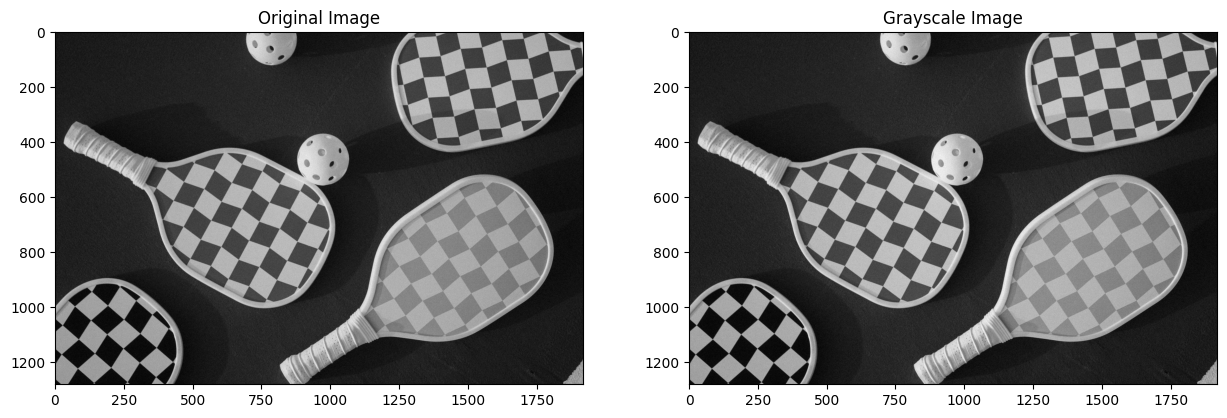

In [3]:
# load and plot the original image since the original image is already grayscale
img = cv2.imread(path + "checkered_pickleball_paddles.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(img)
axes[0].set_title('Original Image')

axes[1].imshow(img_gray, cmap='gray')
axes[1].set_title('Grayscale Image')

plt.show()

#### 1.1 Implement Harris Corner Detection

In [4]:
def harris_corner_detection(img, alpha=0.05, threshold=0.05):
  # to check if the given image is grayscale image
  if img.ndim != 2:
    raise ValueError("Input image must be 2-dimensional (grayscale) image")

  # img = cv2.GaussianBlur(img, (5, 5), 0) # gaussian blur the image

  # sobel derivatives
  Kx = np.array([ [-1, 0, 1],
                  [-2, 0, 2],
                  [-1, 0, 1]], dtype=np.float32)
  Ky = np.array([ [-1, -2, -1],
                  [ 0,  0,  0],
                  [ 1,  2,  1]], dtype=np.float32)

  I_x = cv2.filter2D(img, ddepth=cv2.CV_32F, kernel=Kx, borderType=cv2.BORDER_REFLECT)
  I_y = cv2.filter2D(img, ddepth=cv2.CV_32F, kernel=Ky, borderType=cv2.BORDER_REFLECT)

  # product of image derivatives
  I_xx = np.square(I_x)
  I_yy = np.square(I_y)
  I_xy = I_x * I_y

  # apply gaussian filtering
  I_xx_smooth = cv2.GaussianBlur(I_xx, (3, 3), 0)
  I_yy_smooth = cv2.GaussianBlur(I_yy, (3, 3), 0)
  I_xy_smooth = cv2.GaussianBlur(I_xy, (3, 3), 0)

  # apply corner response function -> R = det(M) - alpha * (trace(M))^2
  det_M = I_xx_smooth * I_yy_smooth - np.square(I_xy_smooth)
  trace_M = I_xx_smooth + I_yy_smooth
  R = det_M - alpha * np.square(trace_M)

  # apply non-maximum suppression
  nms = non_max_suppression(R)

  # normalize
  cv2.normalize(nms, nms, 0, 1, cv2.NORM_MINMAX)

  # apply threshold
  corners = np.where(nms >= threshold)

  # # mark the local maxima
  # for pt in zip(*corners[::-1]):
  #   cv2.circle(img, pt, 5, (255, 0, 0), -1)

  return corners

# non_maximum suppression helper function
def non_max_suppression(img):
  M, N = img.shape
  suppressed = np.zeros_like(img)
  for i in range(1, M-1):
    for j in range(1, N-1):
      if img[i, j] >= img[i-1:i+2, j-1:j+2].max():
        suppressed[i, j] = img[i, j]
      else:
        suppressed[i, j] = 0

  return suppressed

#### 1.2 Visualize Harris Corners

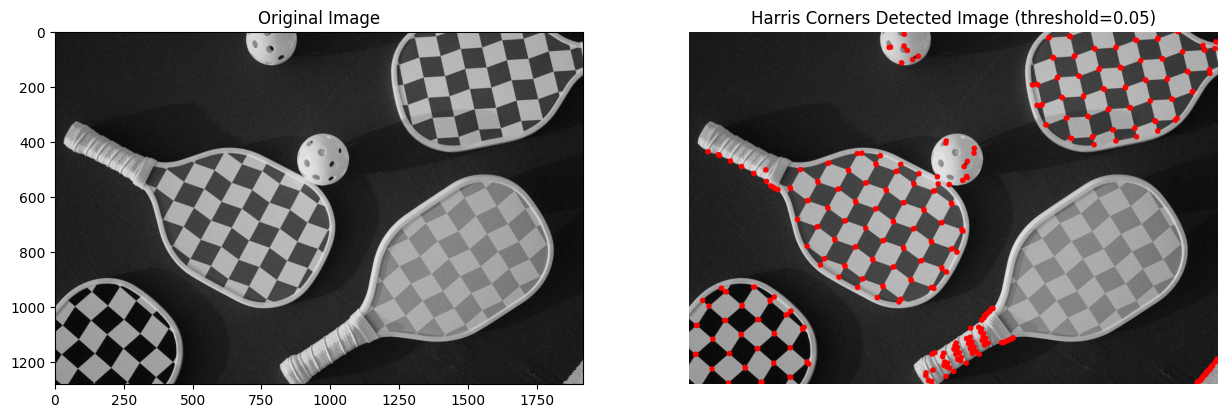

In [5]:
def visualize_corners(img, corners):
  img_disp = img.copy()

  for pt in zip(*corners[::-1]):
    cv2.circle(img_disp, pt, 10, (255, 0, 0), -1)

  # plt.imshow(img_disp)
  # plt.show()

  return img_disp

threshold_value= 0.05
img_disp = visualize_corners(img, harris_corner_detection(img_gray, threshold=threshold_value))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(img)
axes[0].set_title('Original Image')

axes[1].imshow(img_disp)
axes[1].set_title(f"Harris Corners Detected Image (threshold={threshold_value})")

plt.axis('off')
plt.show()

#### 1.3 Threshold Exploration

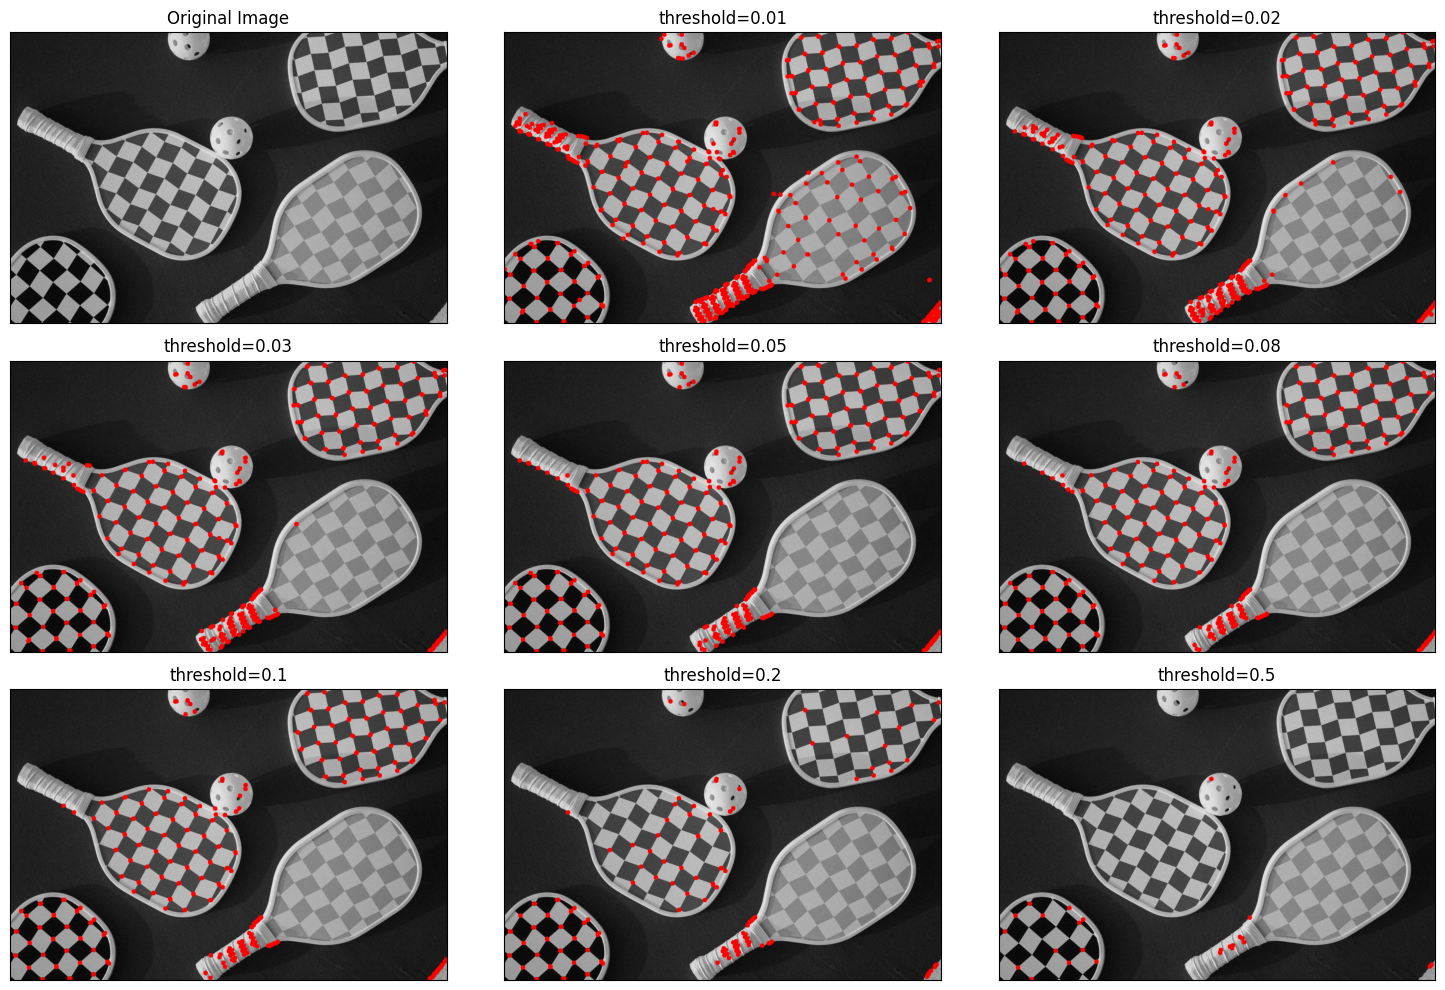

In [6]:
subplot = 332

plt.figure(figsize=(15, 10))
plt.subplot(331)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.imshow(img)

# list of multiple threshold values
threshold_list = [0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.2, 0.5]

for threshold in threshold_list:
  corners = harris_corner_detection(img_gray, threshold=threshold)
  img_disp = visualize_corners(img, corners)

  plt.subplot(subplot)
  plt.title(f"threshold={threshold}"), plt.xticks([]), plt.yticks([])
  plt.imshow(img_disp)

  subplot += 1

plt.tight_layout()
plt.show()

##### Discussion:

I have explored with 8 different threshold values as shown above from 0.01 to 0.5. The top leftmost plot is the original image and the other 8 plots are the original image with marked corners using different threshold values. I noticed that varying the Harris threshold trades recall for precision. At low thresholds (0.01–0.03), many detections include weak responses and noise so the image looks cluttered with red points on textures and speckles. Moderate thresholds (0.05–0.1) suppress most of the noise while preserving true structure like checkerboard intersections and paddle tips, showing a good behavior of harris corner detection. High thresholds (0.2-0.5) keep only the very strongest corners, so many valid but lower contrast corners are not detected. As a result, we must use a relative threshold and adjust alongside your NMS window to control clustering.



#### 1.4 Harris Corners in Transformed Images (Rotation and Scaling)

##### Scaling:

In [7]:
def scale_image(img, scale_factors):
  scaled_images = []
  height, width = img.shape[:2]

  for scale in scale_factors:
    matrix = cv2.getRotationMatrix2D((width / 2, height / 2), 0, scale)
    scaled_image = cv2.warpAffine(img, matrix, (width, height))
    scaled_images.append(scaled_image)

  return scaled_images


def display_scaled_images(scaled_images, scale_factors):
  subplot = 442

  for i in range(len(scaled_images)):
    plt.subplot(subplot)
    plt.title(f"scale={scale_factors[i]}"), plt.xticks([]), plt.yticks([])
    plt.imshow(scaled_images[i])

    subplot += 1

  plt.tight_layout()
  plt.show()

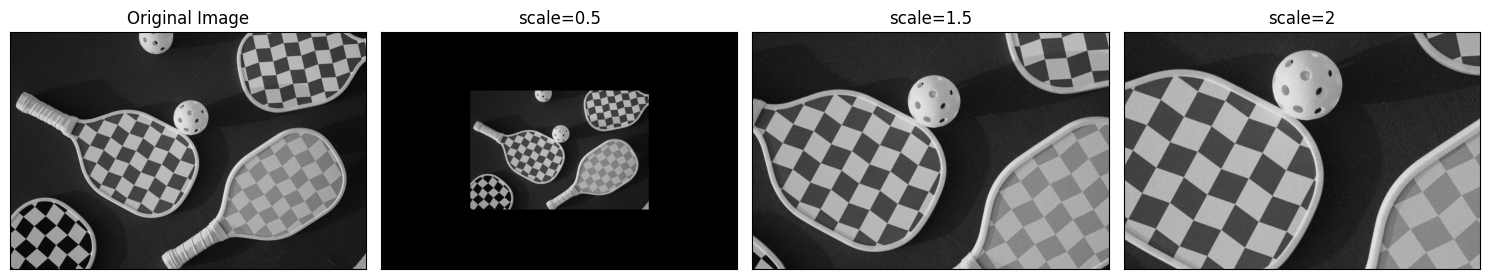

In [8]:
# Display the scaled images

plt.figure(figsize=(15, 15))
plt.subplot(441)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.imshow(img)

scale_factors = [0.5, 1.5, 2]
scaled_images = scale_image(img, scale_factors)
display_scaled_images(scaled_images, scale_factors)

##### Rotation:

In [9]:
# def rotate_image(img, angles):
#   rotated_images = []
#   height, width = img.shape[:2]

#   for angle in angles:
#     matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
#     rotated_image = cv2.warpAffine(img, matrix, (width, height))
#     rotated_images.append(rotated_image)

#   return rotated_images

def rotate_image(img, angles):
  rotated_images = []
  height, width = img.shape[:2]
  cx, cy = width / 2.0, height / 2.0

  for angle in angles:
    matrix = cv2.getRotationMatrix2D((cx, cy), angle, 1)

    cos = np.abs(matrix[0, 0])
    sin = np.abs(matrix[0, 1])
    width_new = int((height * sin) + (width * cos))
    height_new = int((height * cos) + (width * sin))

    matrix[0, 2] += (width_new / 2.0) - cx
    matrix[1, 2] += (height_new / 2.0) - cy

    rotated_image = cv2.warpAffine(img, matrix, (width_new, height_new))
    rotated_images.append(rotated_image)

  return rotated_images

def display_rotated_images(rotated_images, angles):
  subplot = 442

  for i in range(len(rotated_images)):
    plt.subplot(subplot)
    plt.title(f"angle={angles[i]}"), plt.xticks([]), plt.yticks([])
    plt.imshow(rotated_images[i])

    subplot += 1

  plt.tight_layout()
  plt.show()

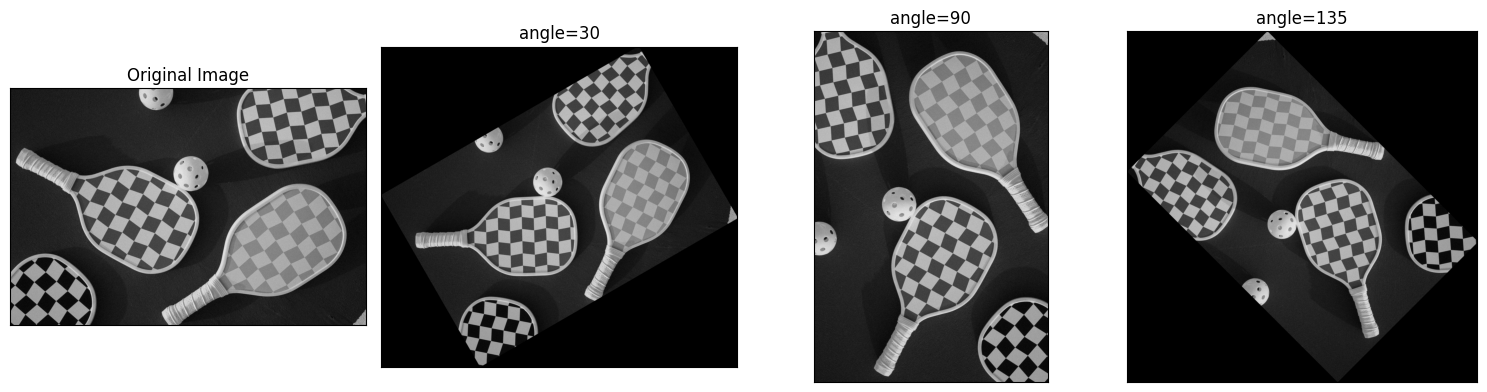

In [10]:
# Display the rotated images

plt.figure(figsize=(15, 15))
plt.subplot(441)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.imshow(img)

angles = [30, 90, 135]
rotated_images = rotate_image(img, angles)
display_rotated_images(rotated_images, angles)

##### Detect Corners:

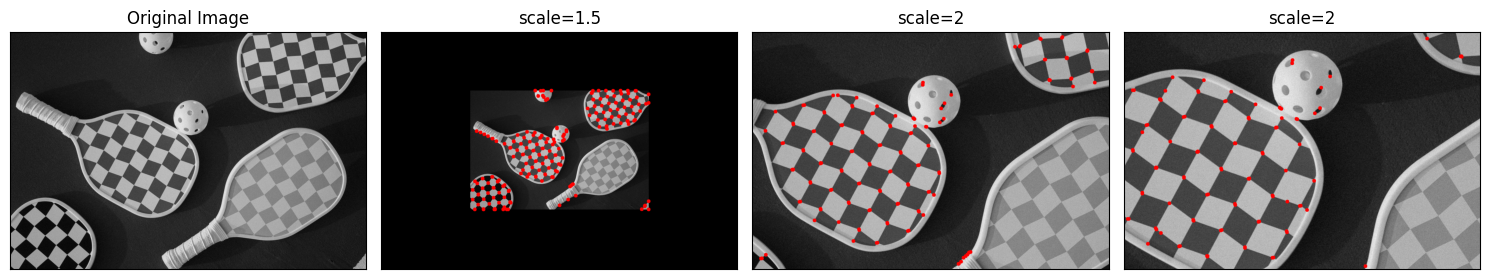

In [11]:
# Harris Corners in Transformed Images (Scaled images)
plt.figure(figsize=(15, 15))
plt.subplot(441)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.imshow(img)

scale_factors = [0.5, 1.5, 2]
scaled_images = scale_image(img, scale_factors)

subplot = 442

for image in scaled_images:
  image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  corners = harris_corner_detection(image_gray, threshold=0.1)
  img_disp = visualize_corners(image, corners)

  plt.subplot(subplot)
  plt.title(f"scale={scale_factors[subplot%4-1]}"), plt.xticks([]), plt.yticks([])
  plt.imshow(img_disp)

  subplot += 1

plt.tight_layout()
plt.show()

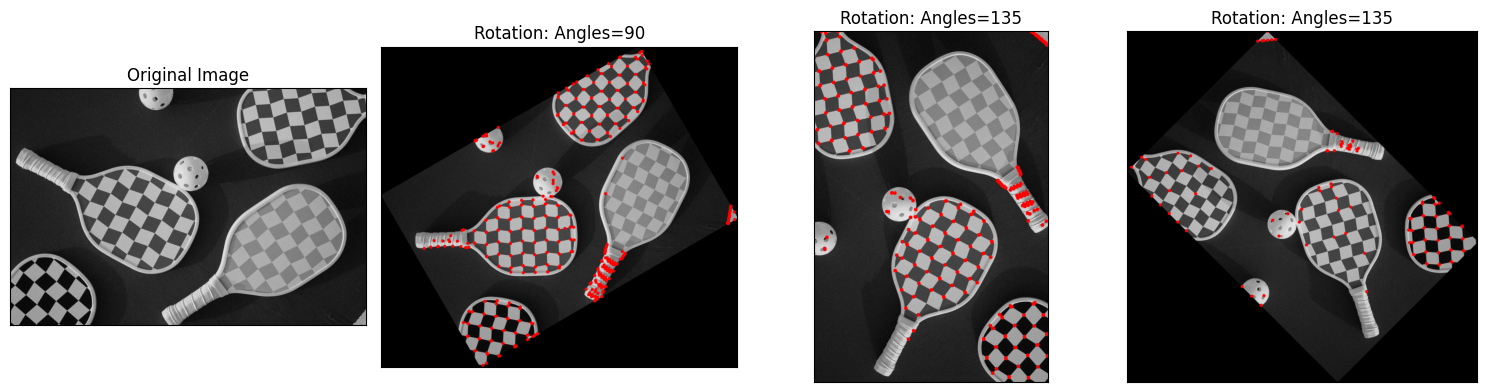

In [12]:
# Harris Corners in Transformed Images (Rotated images)
plt.figure(figsize=(15, 15))
plt.subplot(441)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.imshow(img)

angles = [30, 90, 135]
rotated_images = rotate_image(img, angles)

subplot = 442

for image in rotated_images:
  image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  corners = harris_corner_detection(image_gray, threshold=0.1)
  img_disp = visualize_corners(image, corners)

  plt.subplot(subplot)
  plt.title(f"Rotation: Angles={angles[subplot%4-1]}"), plt.xticks([]), plt.yticks([])
  plt.imshow(img_disp)

  subplot += 1

plt.tight_layout()
plt.show()

##### Discussion: NEED UPDATE

Harris responds to points where intensity changes in two orthogonal directions, so true checker-board junctions are largely rotation-invariant (they remain corners after a rotation), but their numeric strength can vary a bit due to interpolation blur and your Gaussian/NMS settings. Scaling changes both the magnitude and spatial density of gradients: when you down-scale, nearby junctions merge and gradients weaken, so fewer/weaker responses survive a fixed threshold; when you up-scale, junctions spread apart and are sampled with more pixels, so more points pass NMS/threshold and you see denser detections. The prominent “frame” of detections you see along the borders in the transformed images is an artifact of the resampling: rotating or scaling into a larger canvas with BORDER_CONSTANT (black padding) creates a sharp, high-contrast step between image content and the black background; at the four corners of that inner rectangle the gradient changes in two directions, producing very large Harris responses—hence many false “corners” along the border. To avoid these artifacts, crop to the valid region, rotate/scale with an alpha mask and exclude zero-alpha pixels from detection (best), or use a non-constant border mode and/or a mask to ignore the padded perimeter; also tune the Gaussian window and NMS radius proportionally to scale to maintain comparable corner saliency across transformations.

### 2. SIFT Feature Detection

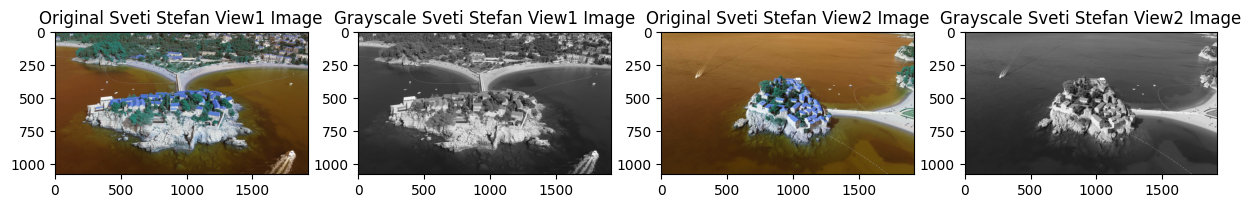

In [27]:
img1 = cv2.imread(path + "sveti_stefan_view1.png")
img2 = cv2.imread(path + "sveti_stefan_view2.png")

img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

fig, axes = plt.subplots(1, 4, figsize=(15, 10))
axes[0].imshow(img1)
axes[0].set_title('Original Sveti Stefan View1 Image')

axes[1].imshow(img1_gray, cmap='gray')
axes[1].set_title('Grayscale Sveti Stefan View1 Image')

axes[2].imshow(img2, cmap='gray')
axes[2].set_title('Original Sveti Stefan View2 Image')

axes[3].imshow(img2_gray, cmap='gray')
axes[3].set_title('Grayscale Sveti Stefan View2 Image')

plt.show()

#### 2.1 Implement SIFT Keypoint Detection and Matching

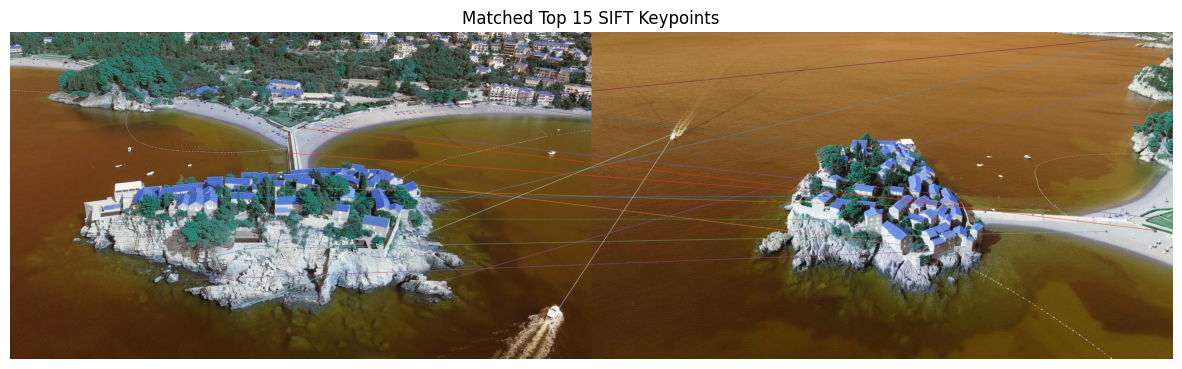

In [39]:
def sift_keypoints_matching(img1, img2, ratio=0.75):
  # detect keypoints and descriptors
  sift = cv2.SIFT_create()

  keypoint1, descriptor1 = sift.detectAndCompute(img1, None)
  keypoint2, descriptor2 = sift.detectAndCompute(img2, None)

  # brute-force matching
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

  # Lowe's ratio test (filtering out ambiguous matches using K-nearest neighbors)
  knn = bf.knnMatch(descriptor1, descriptor2, k=2)

  matches = []
  for m, n in knn:
    if m.distance < ratio * n.distance:
      matches.append(m)

  # sort the matches in the order of their distance
  matches_sorted = sorted(matches, key=lambda x: x.distance)

  # draw top 15 matches
  top15_matches = matches_sorted[:15]
  img_matches = cv2.drawMatches(img1, keypoint1, img2, keypoint2, top15_matches,
                                None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

  return matches_sorted, img_matches

# display top 15 matches
matches_sorted, img_matches = sift_keypoints_matching(img1, img2)

plt.figure(figsize=(15, 10))
plt.imshow(img_matches)
plt.title('Matched Top 15 SIFT Keypoints')
plt.axis('off')
plt.show()

##### Histogram

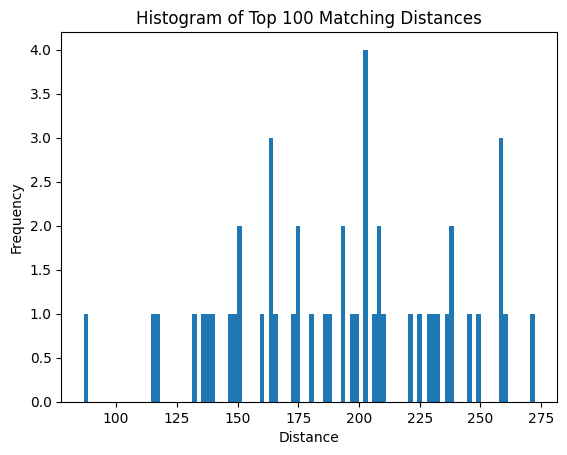

In [40]:
# histogram of matching distances for top 100 matches
distances = [match.distance for match in matches_sorted[:100]]

plt.hist(distances, bins=100)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Top 100 Matching Distances')
plt.show()

##### Discussion: NEED UPDATE

Overall, the match quality looks mediocre: most of the “top-100” distances cluster at high values (~160–190) with only a small tail of low distances (<100). Because SIFT uses L2 distance on 128-D descriptors, smaller is better; the dominance of large distances means many of these matches are weak or ambiguous, and only a minority are strong, reliable correspondences. If you used them as-is, you’d expect many outliers in geometric estimation. You should filter aggressively—apply Lowe’s ratio test (≈0.7–0.8), enforce cross-check (mutual) matching, and then run RANSAC for spatial verification; optionally lower SIFT’s contrast/edge thresholds or keep only matches below a percentile (e.g., best 25–40%) to improve robustness.

///

The updated histogram still suggests weak overall match quality. Most of your “top-100” SIFT distances sit high (roughly 150-260+) with only a few low-distance matches (<120). Because SIFT uses L2 distance on 128-D descriptors, smaller = more similar, so a distribution dominated by large distances—and without a clear low-distance cluster—means many correspondences are ambiguous or incorrect. In practice, you should filter more aggressively: switch to KNN (k=2) + Lowe’s ratio test (~0.7–0.8), require mutual (cross-check) matches, and then run RANSAC (homography or fundamental matrix) to keep only geometrically consistent pairs. If matches remain weak, consider RootSIFT/descriptor normalization, tuning SIFT’s contrastThreshold/edgeThreshold, improving image contrast, or limiting matches to inlier-rich regions.

#### 2.2 SIFT Keypoints on Transformed Images (Rotation and Scaling)

##### Rotate and Scale Image 1

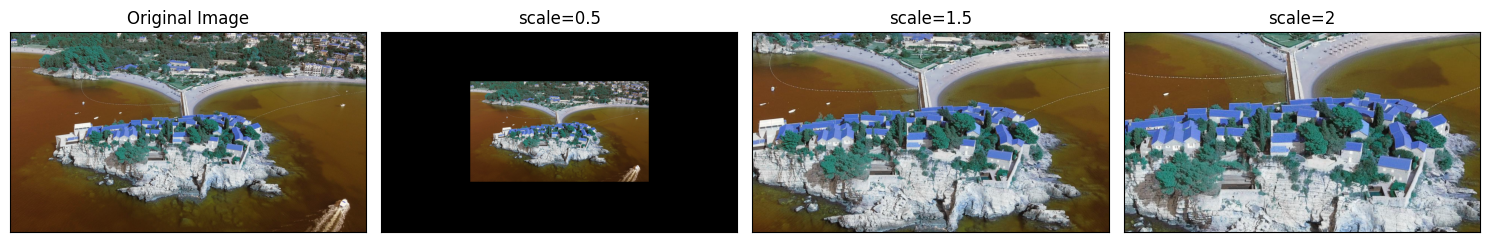

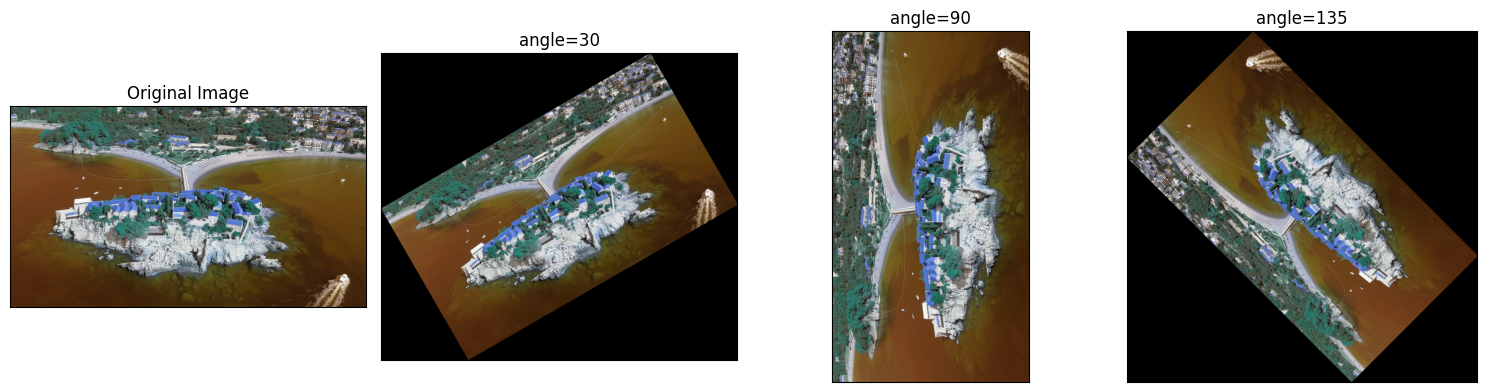

In [41]:
# Display the scaled images
plt.figure(figsize=(15, 15))
plt.subplot(441)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.imshow(img1)

scale_factors = [0.5, 1.5, 2]
scaled_images = scale_image(img1, scale_factors)
display_scaled_images(scaled_images, scale_factors)

# Display the rotated images
plt.figure(figsize=(15, 15))
plt.subplot(441)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.imshow(img1)

angles = [30, 90, 135]
rotated_images = rotate_image(img1, angles)
display_rotated_images(rotated_images, angles)

##### Visualize Keypoints

##### Discussions

Hello world

### 3. Image Alignment

#### 3.1 Keypoint Detection and Matching

#### 3.2 Homography Estimation and Verification

#### 3.3 Image Stitching and Blending

#### 3.4 Evaluation and Reflection

Write a short paragraph discussing:

• How well your homography aligned the images.
• Whether you observed ghosting, seams, or misalignments.
• What could be improved.